In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Stability and stiffness

This chapter introduces the concept of stability. It should help you to recognise why we may need modified finite difference formulae, and is warning against careless use of finite difference methods. After completing this chapter you should be able to:

* Describe what is meant by "local" and "global" errors, and how these may be affected by truncation order and problem stability
* Recognise the potential strengths and drawbacks of various explicit and implicit finite difference methods
* Implement an implicit technique, by using a fixed point method to solve the problem $x=F(x)$

## Accuracy

Before introducing the concept of stability, it is useful to revisit what we mean when we understand by the "error" in a solution, and in doing so we may distinguish between two different measurements of accuracy:

**Local error**:<br>
The local error is the size of error introduced at each step. Mathematically, the local error in the finite difference method is determined by the truncation order of the Taylor expansion. For the explicit Euler method the trunction error is $\mathcal{O}(h^2)$, since this is the order of the terms discarded.


**Global error**:<br>
As we are integrating over $1/h$ steps, we expect that by the time we reach the end of the integration domain the global error will be one order less than the local error. So, for the explicit Euler method the global error is $\mathcal{O}(h)$.

This heuristic description is fairly accurate. However, the detailed picture is a little more complicated, as for some problems the local errors are amplified/compounded in subsequent steps, whilst in other problems the errors are damped out.


## Stability

We say that a method is stable if the local errors are not magnified with each step. In some problems the stability depends on the step size used, whilst other problems are *unconditionally* stable.

We will consider an illustrative example, provided by the following problem, which has analytic solution $x=2e^{-5t}$ :

```{math}
:label: stab-exemplar
\frac{\mathrm{d}x}{\mathrm{d}t}=-5x, \quad x(0)=2, \quad x\in[0,10]
```

### Explicit Euler method

First, let us demonstrate the solutions obtained by the explicit Euler method for two rather large step sizes. The numeric estimate is shown in blue and the analytic solution is shown in red. We are using the `eulerf` function defined previously:

In [2]:

def eulerf(f,x0,tRange,h=1e-3,**kwargs):
  tmin,tmax=tRange
  stop=tmax+2*h    
  t = np.arange(tmin,stop,h)  #stop value is not included

  n=len(t);                   #get number of values
  x=np.empty(n); x[0]=x0      #form output array

  for k in range(n-1):
    t1,x1=t[k],x[k]           #labels introduced for convenience
    x2=x1+h*f(t1,x1,**kwargs) #explicit Euler forward step 
    x[k+1]=x2
  
  return t,x

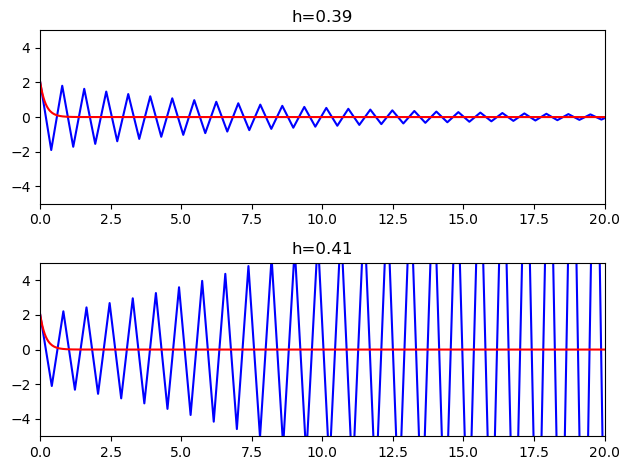

In [3]:
f = lambda t,x: -5*x
tRange=[0,20]

fig,ax = plt.subplots(2,1)

t=np.linspace(*tRange,1000)
xsol = 2*np.exp(-5*t)               #Analytic solution

h=[0.39,0.41]

for i in range(2):
  te,xe=eulerf(f,2,tRange,h[i])     #Explicit Euler
  ax[i].plot(te,xe,'b',t,xsol,'r')
  ax[i].set_title('h=%.2f' % h[i])
  ax[i].set_xlim(tRange)
  ax[i].set_ylim([-5,5])

fig.tight_layout()
plt.show()

We see that the solution appears to be stable for $h=0.39$, despite being very inaccurate. However, when the step size is increased to $h=0.41$ the solution is no longer stable and the local errors increase with every step.


### Implicit Euler scheme

From the backward difference formula {eq}`backwards1` we may obtain the following scheme

$$x_{k+1}= x_{k}+h \dot{x}_{k+1}+\mathcal{O}(h^2).$$

Substituting for $\dot{x}$ from the initial value problem {eq}`ivp1` leads to the following iterative formula, which is known as the implicit Euler method

```{math}
:label: implicitlyeuler
x_{k+1}\simeq x_{k}+h f(t_{k+1},x_{k+1}).
```

Here we encounter a complication, since the expression for $x_k$ is given implicitly. Usually it is not possible to rearrange the expression to obtain an explicit result, so a root-finding algorithm is required, such as the Newton-Raphson technique or a bisection or fixed point algorithm. 

An example implementation is shown in the code below, using `fsolve` from the `scipy` library. To use the root finding function `fsolve`, we need to collect all of the terms in the implicit Euler formula {eq}`implicitlyeuler` onto one side, which gives

\begin{equation}x_{k+1}-x_k-hf(t_{k+1},x_{k+1})=0.\end{equation}

In [4]:
from scipy.optimize import fsolve

def euleri(f,x0,tRange,h=1e-3,**kwargs):
  tmin,tmax=tRange
  stop=tmax+2*h    
  t = np.arange(tmin,stop,h)  #stop value is not included
  
  n=len(t);                   #get number of values
  x=np.empty(n); x[0]=x0      #form output array

  for k in range(n-1):
      t1,x1=t[k],x[k]     #labels introduced for convenience
      t2=t1+h             #this is the same as t[k+1]

      F = lambda x2: (x2-x1-h*f(t2, x2,**kwargs)) 
      x2=fsolve(F,x1)     #Solve backward difference
      x[k+1]=x2       
  return t,x

Now we demonstrate the solutions obtained by the implicit Euler method. The numeric estimate is shown in blue and the analytic solution is shown in red.

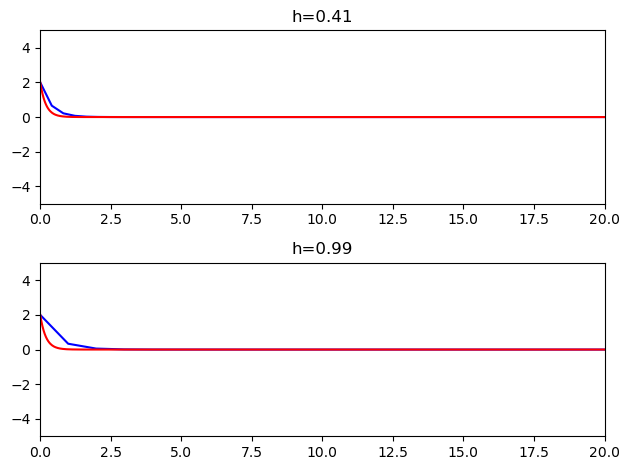

In [5]:
f = lambda t,x: -5*x
tRange=[0,20]

fig,ax = plt.subplots(2,1)

t=np.linspace(*tRange,1000)
xsol = 2*np.exp(-5*t)               #Analytic solution

h=[0.41,0.99]

for i in range(2):
  ti,xi=euleri(f,2,tRange,h[i])     #Implicit Euler
  ax[i].plot(ti,xi,'b',t,xsol,'r')
  ax[i].set_title('h=%.2f' % h[i])
  ax[i].set_xlim(tRange)
  ax[i].set_ylim([-5,5])

fig.tight_layout()
plt.show()

We see that the solution appears to be stable for the step size $h=0.41$ where the explicit method failed. Indeed, it remains stable even for $h=0.99$.

### Interpretation

Both the explicit and implicit Euler solutions have the same level of accuracy over a single step. However, in this example the errors in the explicit solution are amplified, whilst in the implicit solution they are damped. The implicit method is more stable for this example.

This example can be fully analysed by hand. Since it is linear, a root finding method is not needed to implement the backward formula. We can simply rearrange to obtain an explicit solution. 

```{exercise}
For the example problem {eq}`stab-exemplar`, both the explicit and implicit formulae can be applied recursively by hand to obtain a closed form discrete solution $x_k$ in terms of the step size $h$ and the initial condition $x_0$. 

Try to carry out the algebra yourself, and use the result to explain the stability properties we have observed.
```

```{toggle}

The **explicit formula** gives

$$\displaystyle x_k= (1-5h)x_{k-1} \quad \Rightarrow \quad x_{k}=(1-5h)^k x_0, \qquad t=kh$$

The **implicit formula** gives

$$\displaystyle x_k=\frac{x_{k-1}}{1+5h} \quad \Rightarrow \quad x_{k}=\frac{x_0}{(1+5h)^k}, \qquad t=kh$$

Both results converge to the analytic solution in the limit of small step sizes, since

$$\lim_{h\rightarrow 0}(1\pm 5 h)^{t/h} = e^{\pm 5t}.$$

However, the explicit result displays oscillating growth for $|1-5h|>1$  (i.e. for $h>2/5$).

_____________
```



## Practical considerations

Besides the explicit and implicit Euler methods there are a range of other finite difference algorithms that can be used to solve initial value problems. The simplest and most well known of these fall into a category called Runge-Kutta (RK) methods, which take a weighted combination of calculations with different step sizes to mathematically improve the truncation order. The trapezoidal method given in the chapter exercises is a second order implicit RK method.

We should also be aware that improvements in the truncation order may come at a cost: high order explicit methods tend to be less stable, whilst implicit algorithms tend to be more computationally demanding for a given step size. The size of the error at each step depends both on the method used and also the problem being solved. 

To produce a reliable result within specified error tolerances, many algorithms use adaptive step size methods, in which the error is estimated at each step by comparing the results from different algorithms. The step size can then be decreased in regions where the tolerance would be exceeded. The `scipy` package offers a built-in algorithm that does exactly this, called `integrate.solve_ivp`.

```{admonition} Stiffness
:class: theory
For ODEs with a fast decaying or highly oscillatory mode, explicit methods may demand impractically small step sizes so that floating point errors become significant. These types of ODE are called "stiff". Implicit methods tend to be better for such problems due to their generally superior stability. Amongst the implicit methods, the implicit Euler method is particularly stable.
```


## Chapter exercises

**Question 1**<br>

Taking the average of the forward and backward difference formulae gives

```{math}
:label: trapz
y_{k+1}=y_k+\frac{h}{2}\biggr[f(x_k,y_k)+f(x_{k+1},y_{k+1})\biggr]
```

This result is equivalent to approximating the integral using the trapezium rule. It can be shown that the global error in this formula is $\mathcal{O}(h^2)$, whilst the global errors in the explicit and implicit Euler methods are both $\mathcal{O}(h)$. However, it is less stable than the implicit Euler method.

Write an implementiation of the trapezoidal rule by modifying the implicit Euler algorithm outlined above Use your function to solve the logistic problem defined in {eq}`ord1logist`. You can use the plotter function below to compare your numeric solution to the analytic one.

In [6]:
def myplotter(x,y,yexact):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.tight_layout(pad=5.0) #increase subplot spacing
  fig.suptitle('Estimated integral of the given IVP')
  ax1.plot(x, y)
  ax2.plot(x,abs(y-yexact))
  ax1.set(xlabel='$x$',ylabel='Estimate')
  ax2.set(xlabel='$x$',ylabel='Error')
  print('Maximum error:', max(abs(y-yexact)))
  plt.show()
  return

**Question 2**<br>

As an alternative to using Newton-Raphson algorithm to find the root of an algebraic relationship, we can use a fixed-point iteration technique, designed for problems of the form

\begin{equation}x=F(x).\end{equation}

Such techniques are an important numerical analysis tool, and we will use them more when we study applications to partial differential equations. 

The approach proceeds by taking an initial guess $x=x_g$ and substituting it into the right hand side of the equation.

* If $|x_g-F(x_g)|$ is less than some specified tolerance then we conclude that our guess is a good approximation to the root.

* If the tolerance goal is not met, we use the result $F(x_g)$ as a new guess, and repeat the process.

Write your own fixed point iteration code to find a root of $x=\cos(x)$, with an initial guess of $x=0.2$, with a tolerance of $10^{-7}$. Compare your result to the value given by `fsolve`.

**Question 3**<br>
Rewrite the second order ODE given in {eq}`ord2logist` as a first order system subject to the initial condition $x(0)=C/2$, $x^{\prime}(0)=rC/4$. Apply the explicit Euler method to this system. What do you conclude?